In [277]:
%matplotlib inline
import velocyto as vcy
import numpy as np
#import scanpy.api as sc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from copy import deepcopy

#sc.settings.set_figure_params(dpi=80)

In [105]:
#load loom file:
ind4 = vcy.VelocytoLoom("ind4/velocyto_out/possorted_genome_bam_5AUZJ.loom")

#fix barcode names:
ind4.ca['CellID'] = np.array([b.split(":")[1] for b in ind4.ca["CellID"]])

In [170]:
#load marker genes as a dataframe:
ind4_marker_genes = pd.read_table("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/ind4/ind4_marker_genes_trim.txt")
ind4_marker_genes.set_index("gene", inplace=True)

In [187]:
ind4_marker_genes.loc[ind4_marker_genes['cluster'] == 'Basal'].head()

,p_val,avg_diff,pct.1,pct.2,cluster
gene,,,,,
MT2A,0.000000e+00,1.965748,0.982,0.530,Basal
MT1X,1.855603e-263,1.698664,0.785,0.151,Basal
S100A2,4.699100e-242,1.950665,0.773,0.324,Basal
SFN,2.149788e-227,0.968896,0.985,0.686,Basal
MRGPRX3,5.440516e-202,1.198604,0.733,0.163,Basal


In [3]:
#add in cell type identity from list of known cell type identities:
def get_cell_type_identities(cell_id_file, loom_file):
    
    #get cell barcode : identity from cell_id_file
    cell_id_dict = {l.split()[0].split("_")[1] : l.split()[1] for l in open(cell_id_file, 'r').readlines()}

    #get barcodes from loom file:
    loom_barcodes = [b for b in loom_file.ca["CellID"]]
    
    barcode_bool = np.array([True if barcode in cell_id_dict.keys() else False for barcode in loom_barcodes])
    return  np.array([cell_id_dict[barcode] for barcode in loom_barcodes if barcode in cell_id_dict.keys()]), barcode_bool


In [4]:
# remove cells with extremely low unspliced detection
ind4.filter_cells(bool_array=ind4.initial_Ucell_size > np.percentile(ind4.initial_Ucell_size, 0.5))

In [5]:
#filter based on barcode file:
ind4.ca["ClusterName"], barcode_filter = get_cell_type_identities(
    "/home/smudge/Documents/kessenbrock_lab/RNA_velocity/ind4_celltypes.tsv",
    ind4
)
ind4.ca['CellID'] = ind4.ca['CellID'][barcode_filter]

In [6]:
ind4.filter_cells(bool_array = np.array(barcode_filter))


IndexError: boolean index did not match indexed array along dimension 0; dimension is 4022 but corresponding boolean dimension is 7094

In [110]:
#load predicted doublets:
ind4_doublet_file = "/home/smudge/Documents/kessenbrock_lab/Doublet_Pipelines_Data/ind4/ind4_predicted_doublets.tsv"
ind4_doublet_dict = {l.split()[0].split("-")[0] : l.split()[1:] for l in open(ind4_doublet_file, 'r').readlines()[1:]}

#add doublet score and doublet prediction as column attributes:
ind4.ca["doublet_score"] = np.array([ind4_doublet_dict[barcode][0] for barcode in ind4.ca['CellID']])
ind4.ca["doublet_predictions"] = np.array([ind4_doublet_dict[barcode][1] for barcode in ind4.ca['CellID']])

In [7]:
ind4.S.shape

(58676, 4022)

In [8]:
#set clusters to cell type, defined previously
ind4.set_clusters(ind4.ca["ClusterName"])

In [9]:
ind4.score_detection_levels(min_expr_counts=40, min_cells_express=30)
ind4.filter_genes(by_detection_levels=True)

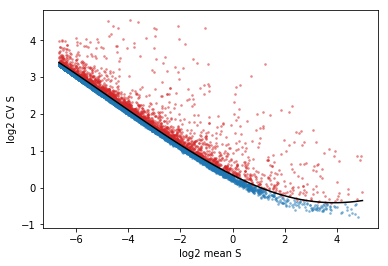

In [10]:
#feature selection:
ind4.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
ind4.filter_genes(by_cv_vs_mean=True)

In [11]:
#normalize data by total molecule count
ind4._normalize_S(relative_size=ind4.S.sum(0), target_size=ind4.S.sum(0).mean())
ind4._normalize_U(relative_size=ind4.U.sum(0), target_size=ind4.U.sum(0).mean())

In [ ]:
# run pca and k-nearest-neighbors
ind4.perform_PCA()
ind4.knn_imputation(n_pca_dims=20, k=500, balanced=True, b_sight=3000, b_maxl=1500, n_jobs=16)

38

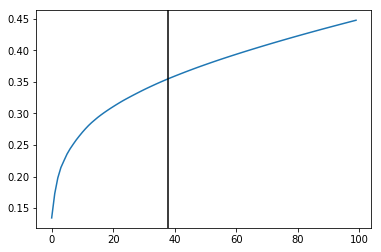

In [31]:
plt.plot(np.cumsum(ind4.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(ind4.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
n_comps

In [32]:
#ind4.fit_gammas()
ind4.fit_gammas(limit_gamma=False, fit_offset=False)

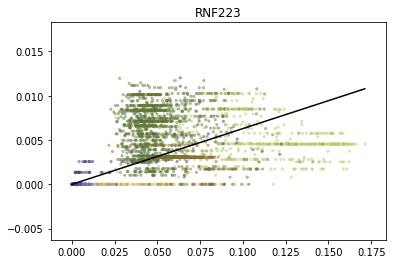

In [33]:
ind4.plot_phase_portraits(["RNF223"]) 


In [34]:
ind4.predict_U()
ind4.calculate_velocity()
ind4.calculate_shift(assumption="constant_velocity")
ind4.extrapolate_cell_at_t(delta_t=1.)

In [16]:
# extrapolate for constant unspliced assumption
# ind4.calculate_shift(assumption="constant_unspliced", delta_t=10)
# ind4.extrapolate_cell_at_t(delta_t=1.)

In [17]:
bh_tsne = TSNE()
ind4.ts = bh_tsne.fit_transform(ind4.pcs[:, :25])


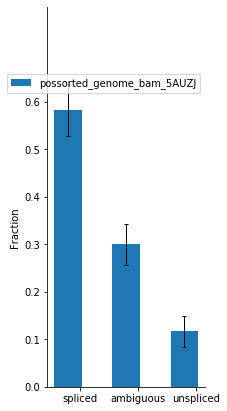

In [30]:
ind4.plot_fractions()

In [35]:
ind4.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=3500, knn_random=True, sampled_fraction=0.5)
ind4.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

In [76]:
? ind4.plot_grid_arrows()

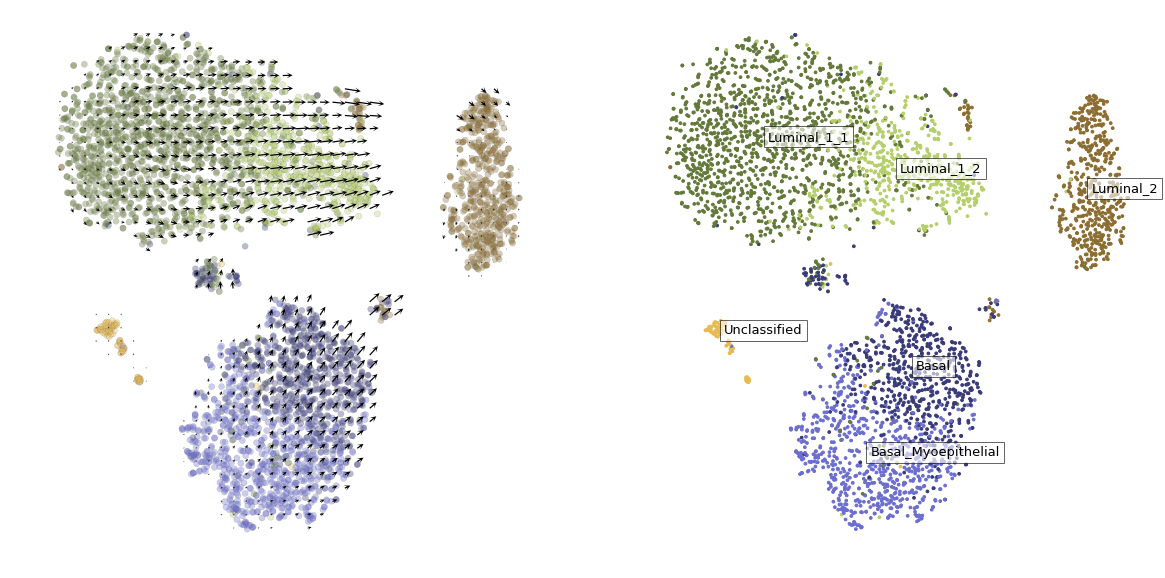

In [113]:
#velocity tsne
ind4.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=300)
#plt.figure(None,(10,10))
f, ax = plt.subplots(1,2, figsize=(20,10))
plt.subplot(121)
ind4.plot_grid_arrows(quiver_scale=0.15,
                    scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=1, angles='xy', scale_units='xy',
                    headaxislength=2.75, headlength=5, headwidth=4.8, minlength=0.35,
                    plot_random=False, scale_type='absolute')

#tsne with cluster names
plt.subplot(122)
vcy.scatter_viz(ind4.ts[:,0], ind4.ts[:,1], c=ind4.colorandum, s=7.5)
#for i in range(max(ind4.ca["ClusterName"])):
for i in list(set(ind4.ca["ClusterName"])):
    ts_m = np.median(ind4.ts[ind4.ca["ClusterName"] == i, :], 0)
    plt.text(ts_m[0], ts_m[1], str(ind4.cluster_labels[ind4.ca["ClusterName"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6})
plt.axis("off");

In [160]:
? ind4

In [229]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

lgb = truncate_colormap(plt.get_cmap('binary'),0.2)

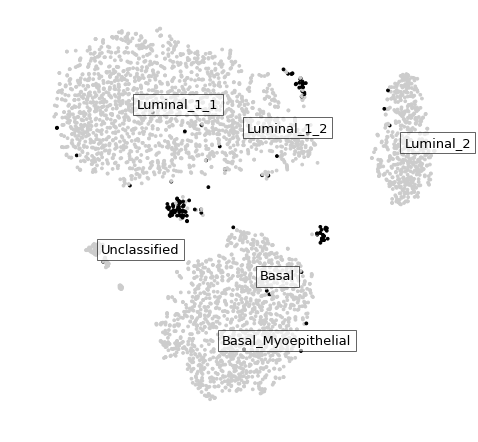

In [240]:
f, ax = plt.subplots(1,1, figsize=(7.5,7.5))
plt.subplot(111)

vcy.scatter_viz(ind4.ts[:,0], ind4.ts[:,1], c=ind4.ca['doublet_predictions'], s=7.5, cmap=lgb)
for i in list(set(ind4.ca["ClusterName"])):
    ts_m = np.median(ind4.ts[ind4.ca["ClusterName"] == i, :], 0)
    plt.text(ts_m[0], ts_m[1], str(ind4.cluster_labels[ind4.ca["ClusterName"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6})
plt.axis("off");


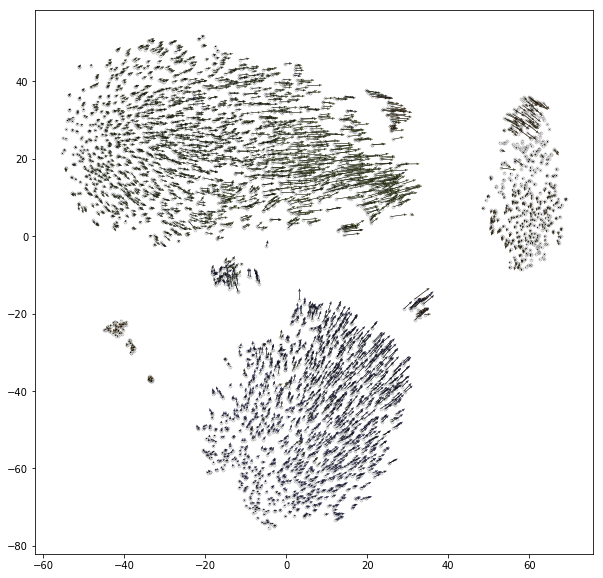

In [65]:
plt.figure(None,(10,10))
quiver_scale = 25
plt.scatter(ind4.embedding[:, 0], ind4.embedding[:, 1],
            c="0.8", alpha=0.2, s=10, edgecolor="")

ix_choice = np.random.choice(ind4.embedding.shape[0], size=int(ind4.embedding.shape[0]/1.), replace=False)
plt.scatter(ind4.embedding[ix_choice, 0], ind4.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=ind4.colorandum[ix_choice], alpha=1)
plt.quiver(ind4.embedding[ix_choice, 0], ind4.embedding[ix_choice, 1],
           ind4.delta_embedding[ix_choice, 0], ind4.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)


In [33]:
ind4.ca['CellID'][np.array(barcode_filter)].shape

(4022,)

In [188]:
ind4_marker_genes.loc[ind4_marker_genes['cluster'] == 'Basal'].head()

,p_val,avg_diff,pct.1,pct.2,cluster
gene,,,,,
MT2A,0.000000e+00,1.965748,0.982,0.530,Basal
MT1X,1.855603e-263,1.698664,0.785,0.151,Basal
S100A2,4.699100e-242,1.950665,0.773,0.324,Basal
SFN,2.149788e-227,0.968896,0.985,0.686,Basal
MRGPRX3,5.440516e-202,1.198604,0.733,0.163,Basal


### Phase plot, velocity, and expression for marker genes

In [193]:
# plotting utility functions
def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    
def minimal_xticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    xlims = np.linspace(start, end_, 5)
    xlims_tx = [""]*len(xlims)
    xlims_tx[0], xlims_tx[-1] = f"{xlims[0]:.0f}", f"{xlims[-1]:.02f}"
    plt.xticks(xlims, xlims_tx)

    
def minimal_yticks(start, end):
    end_ = np.around(end, -int(np.log10(end))+1)
    ylims = np.linspace(start, end_, 5)
    ylims_tx = [""]*len(ylims)
    ylims_tx[0], ylims_tx[-1] = f"{ylims[0]:.0f}", f"{ylims[-1]:.02f}"
    plt.yticks(ylims, ylims_tx)

In [211]:
count = 0
gene_list = []
for gene in list(ind4_marker_genes.loc[ind4_marker_genes['cluster'] == 'Basal'].index):
    if gene in ind4.ra["Gene"] and gene != "SFN":
        gene_list.append(gene)
        count+=1
    if count == 6:
        break

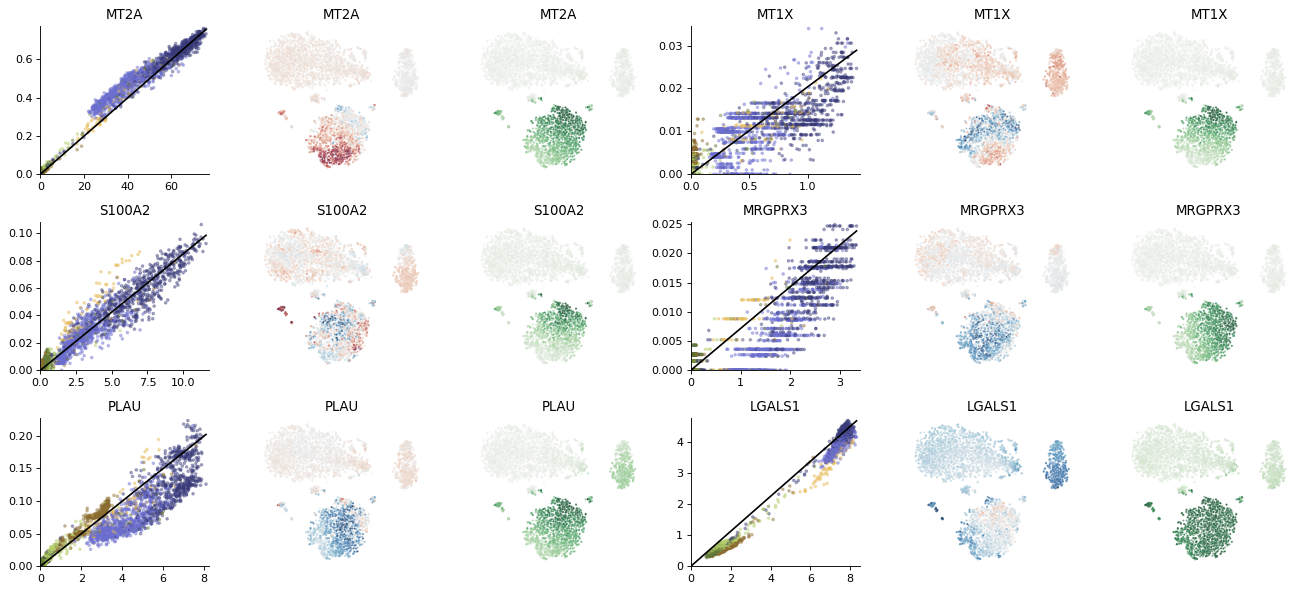

In [215]:

plt.figure(None, (16.5,7.5), dpi=80)
gs = plt.GridSpec(3,6)
for i, gn in enumerate(gene_list):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(ind4.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(ind4.Sx_sz[ix,:], ind4.Ux_sz[ix,:], c=ind4.colorandum, s=5, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,ind4.Sx[ix,:].max())
    plt.plot(xnew, ind4.gammas[ix] * xnew + ind4.q[ix], c="k")
    plt.ylim(0, np.max(ind4.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(ind4.Sx_sz[ix,:])*1.02)
    #minimal_yticks(0, np.max(ind4.Ux_sz[ix,:])*1.02)
    #minimal_xticks(0, np.max(ind4.Sx_sz[ix,:])*1.02)
    despline()
    
    ind4.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)
    ind4.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    
plt.tight_layout()
#plt.savefig("../figures/Suppl_phase_selection.pdf")

### Zoomed in velocity t-sne plot

In [216]:
def gaussian_kernel(X, mu = 0, sigma=1):
    return np.exp(-(X - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

In [217]:
from scipy.stats import norm
from sklearn.neighbors import NearestNeighbors

(-80, -10)

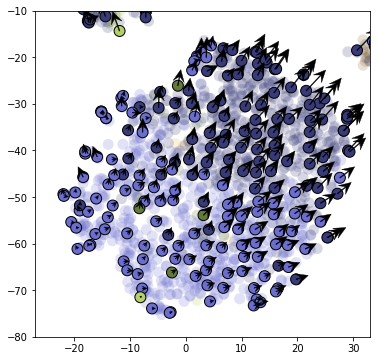

In [225]:
plt.figure(None,(6,6))

steps = 45, 45
grs = []
for dim_i in range(ind4.embedding.shape[1]):
    m, M = np.min(ind4.embedding[:, dim_i]), np.max(ind4.embedding[:, dim_i])
    m = m - 0.025 * np.abs(M - m)
    M = M + 0.025 * np.abs(M - m)
    gr = np.linspace(m, M, steps[dim_i])
    grs.append(gr)

meshes_tuple = np.meshgrid(*grs)
gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
gridpoints_coordinates = gridpoints_coordinates + norm.rvs(loc=0, scale=0.15, size=gridpoints_coordinates.shape)

nn = NearestNeighbors()
nn.fit(ind4.embedding)
dist, ixs = nn.kneighbors(gridpoints_coordinates, 20)
ix_choice = ixs[:,0].flat[:]
ix_choice = np.unique(ix_choice)

nn = NearestNeighbors()
nn.fit(ind4.embedding)
dist, ixs = nn.kneighbors(ind4.embedding[ix_choice], 20)
density_extimate = gaussian_kernel(dist, mu=0, sigma=0.5).sum(1)
bool_density = density_extimate > np.percentile(density_extimate, 25)
ix_choice = ix_choice[bool_density]

plt.scatter(ind4.embedding[:, 0], ind4.embedding[:, 1],
            c=ind4.colorandum, alpha=0.2, s=120, edgecolor="")
plt.scatter(ind4.embedding[ix_choice, 0], ind4.embedding[ix_choice, 1],
            c=ind4.colorandum[ix_choice], alpha=1, s=120, edgecolor="k")

quiver_kwargs=dict(scale=6.8, headaxislength=9, headlength=15, headwidth=14,linewidths=0.4, edgecolors="k", color="k", alpha=1)
plt.quiver(ind4.embedding[ix_choice, 0], ind4.embedding[ix_choice, 1],
           ind4.delta_embedding[ix_choice, 0], ind4.delta_embedding[ix_choice, 1],
           **quiver_kwargs)

plt.xlim(-27,33) 
plt.ylim(-80,-10)

### Pseudotime analysis

In [278]:
ind4_pseudotime = deepcopy(ind4)

In [273]:
#Wrap implementation
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    d = {'print.me': 'print_dot_me', 'print_me': 'print_uscore_me'}
    princurve = importr("princurve", on_conflict='warn')
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

In [247]:
from sklearn.neighbors import NearestNeighbors
import igraph

nn = NearestNeighbors(50)
nn.fit(ind4.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [249]:
from numpy_groupies import aggregate, aggregate_np

In [274]:
pc_obj = principal_curve(ind4.pcs[:,:4], False)
pc_obj.arclength = np.max(pc_obj.arclength) - pc_obj.arclength
labels = np.argsort(np.argsort(aggregate_np(labels, pc_obj.arclength, func=np.median)))[labels]

/home/smudge/anaconda3/lib/python3.6/site-packages/rpy2/robjects/packages_utils.py:107: UserWarning: Conflict when converting R symbols in the package "princurve" to Python symbols: 
-lines_principal_curve -> lines.principal_curve, lines.principal.curve
- plot_principal_curve -> plot.principal_curve, plot.principal.curve
- points_principal_curve -> points.principal_curve, points.principal.curve
  warn(msg)


In [279]:
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
ind4_pseudotime.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [280]:
k = 550
ind4_pseudotime.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, ind4_pseudotime.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, ind4_pseudotime.S.shape[1]-1))

In [281]:
ind4_pseudotime.normalize_median()
ind4_pseudotime.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [283]:
ind4_pseudotime.normalize(which="imputed", size=False, log=True)
ind4_pseudotime.Pcs = np.array(ind4_pseudotime.pcs[:,:2], order="C")

In [284]:
ind4_pseudotime.predict_U()
ind4_pseudotime.calculate_velocity()
ind4_pseudotime.calculate_shift()
ind4_pseudotime.extrapolate_cell_at_t(delta_t=1)

In [285]:
ind4_pseudotime.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)

In [286]:
ind4_pseudotime.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)


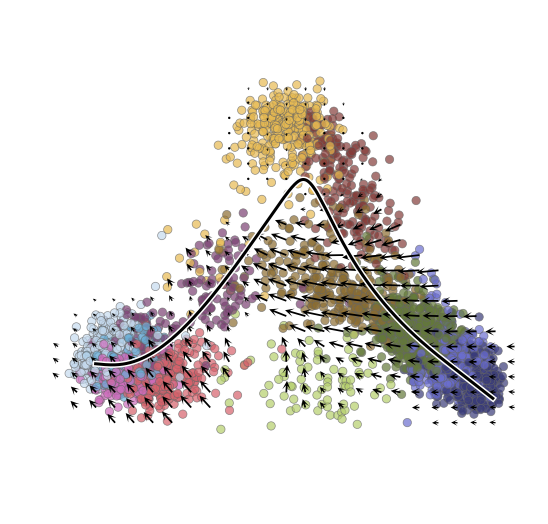

In [287]:
plt.figure(None,(9,9))
ind4_pseudotime.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");

In [290]:
#save ind4 object and ind4_pseudotime object
vcy.serialization.dump_hdf5(ind4, "/home/smudge/Documents/kessenbrock_lab/RNA_velocity/ind4/ind4.hdf5")
vcy.serialization.dump_hdf5(ind4_pseudotime,"/home/smudge/Documents/kessenbrock_lab/RNA_velocity/ind4/ind4_pseudotime.hdf5")


#load ind4
# load_velocyto_hdf5("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/ind4/ind4.hdf5")
# load_velocyto_hdf5("/home/smudge/Documents/kessenbrock_lab/RNA_velocity/ind4/ind4_pseudotime.hdf5")



TypeError: No conversion path for dtype: dtype('<U19')

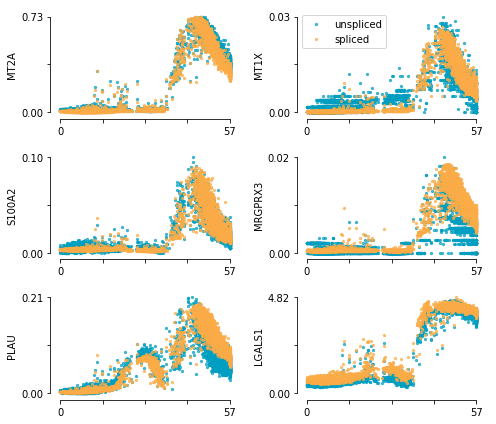

In [292]:
plt.figure(None, (7,6.))
gs = plt.GridSpec(3,2)
for n, gene in enumerate(gene_list):
    i = np.where(ind4_pseudotime.ra["Gene"] == gene)
    ax = plt.subplot(gs[n])
    plt.scatter(pc_obj.arclength[pc_obj.ixsort], ind4_pseudotime.Ux_sz[i, pc_obj.ixsort],
                alpha=0.7, c=np.array([0,159,193])/255, s=5, label="unspliced")
    plt.scatter(pc_obj.arclength[pc_obj.ixsort], ind4_pseudotime.Sx_sz[i, pc_obj.ixsort]*ind4_pseudotime.gammas[i],
                alpha=0.7, c=np.array([251, 172, 71])/255, s=5, label="spliced")
    m = 0 #np.minimum(np.min(ind4_pseudotime.Ux_sz[i,:]), np.min(ind4_pseudotime.Sx_sz[i,:]*ind4_pseudotime.gammas[i]))
    M = np.maximum(np.max(ind4_pseudotime.Ux_sz[i,:]), np.max(ind4_pseudotime.Sx_sz[i,:]*ind4_pseudotime.gammas[i]))
    plt.ylim(m - 0.07*(M-m), M + 0.07*(M-m))
    plt.ylabel(gene)
    plt.yticks([m,0.5*(m+M),M], [f"{m:.2f}", "", f"{M:.2f}"])
    p = np.min(pc_obj.arclength[pc_obj.ixsort])
    P = np.max(pc_obj.arclength[pc_obj.ixsort])
    plt.xticks(np.linspace(p,P,5), [f"{p:.0f}", "","","", f"{P:.0f}"])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_bounds(m, M)
    ax.spines['bottom'].set_bounds(p, P)
    if n == 1:
        plt.legend()
plt.tight_layout()